# Student Performance Predictions Analysis

# Imports

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Functions

In [64]:
def plot_distribution(df, dist_type):
  
  plt.figure(figsize=(16, 16))
  rows = len(df.columns)
  dims = (rows+ 4)//3
  
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if dist_type == "hist" else sns.boxplot(df[col])
    plt.title(f"Distirbution of {col}") if dist_type == "hist" else plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()

def create_preprocessor(numeric_cols, categorical_cols):
  
  numeric_transformer = Pipeline(
    steps=[("Scaler", MinMaxScaler())
    ]
  )
  
  categorical_transformer = Pipeline(
    steps=[
      ("Encoder", OneHotEncoder())
    ]
  )
  
  return ColumnTransformer(
    transformers = [
      ("Categorical", categorical_transformer, categorical_cols),
      ("Numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append({
      "Component":component,
      "CumSum": cumsum
    })
  
  df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(20, 12))
  plt.title("PCA Analysis")
  plt.xlabel("Component")
  plt.ylabel("CumSum")
  sns.barplot(data=df, x="Component", y="CumSum")
  plt.show()
  return df

def get_selected_models(names):
  models = {
        "SVR": SVR(),
        "LR": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "DTR": DecisionTreeRegressor(),
        "GBR": GradientBoostingRegressor(),
        "RFR": RandomForestRegressor(),
        "XGB": XGBRegressor(),
        "LASSO": Lasso(),
        "RIDGE": Ridge(),
        "DUMMY": DummyRegressor(strategy="mean")
    }
    
  return [models[model] for model in names]

def get_metrics(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    exp = explained_variance_score(y, predictions)
    
    return [mae, mse, rmse, r2, exp]

def evaluate_model(model, X, y, metric):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
    mae, mse, rmse, r2, exp = get_metrics(y, preds)
    
    return [
        round(np.mean(scores), 3), 
        round(np.var(scores), 3), 
        round(np.std(scores), 3), 
        round(mae, 3), 
        round(mse, 3),
        round(np.sqrt(rmse), 3),
        round(r2, 3),
        round(exp, 3)
    ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
    metric_tracker = []
    
    for model, model_name in zip(models, model_names):
        pipeline = create_sklearn_pipeline(preprocessor, model, kbest) if kbest else create_sklearn_pipeline(preprocessor,model) 
        scores = evaluate_model(pipeline, X, y, scoring_metric)
        metric_tracker.append({
            "Model": model_name,
            "Mean": scores[0],
            "Var": scores[1],
            "STD": scores[2],
            "MAE": scores[3],
            "MSE": scores[4],
            "RMSE": scores[5],
            "R2": scores[6],
            "Explained Var": scores[7]
        })
    
    return pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True)

def test_kbest_columns(preprocessor ,X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)

    metric_tracker.append({
            "Model": model_name,
            'K':k,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
    
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor, model, kbest)

    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=6, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)
      
    print(f"The Best Param: {best_params} for Model: {model_name}")
    metric_tracker.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
  
  return pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True)

# EDA Analysis

In [13]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/student_performance.csv")
df

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85
5,6,Olivia,Female,95,30,88,1,High,90
6,7,Daniel,Male,70,8,60,0,Low,62
7,8,Sophia,Female,85,17,77,1,Medium,78
8,9,James,Male,82,12,70,2,Low,72
9,10,Isabella,Female,91,22,86,3,High,88


In [14]:
df.drop(["StudentID", 'Name'], axis=1, inplace=True)

In [15]:
new_df = df.copy()

mapping = {"High":2,"Medium":1, "Low":0}
new_df["Gender"] = df["Gender"].apply(lambda x: 0 if x == "Male" else 1)
new_df["ParentalSupport"] = new_df["ParentalSupport"].map(mapping)

In [16]:
new_df

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,0,85,15,78,1,2,80
1,1,90,20,85,2,1,87
2,0,78,10,65,0,0,68
3,0,92,25,90,3,2,92
4,1,88,18,82,2,1,85
5,1,95,30,88,1,2,90
6,0,70,8,60,0,0,62
7,1,85,17,77,1,1,78
8,0,82,12,70,2,0,72
9,1,91,22,86,3,2,88


# HeatMap

<Axes: >

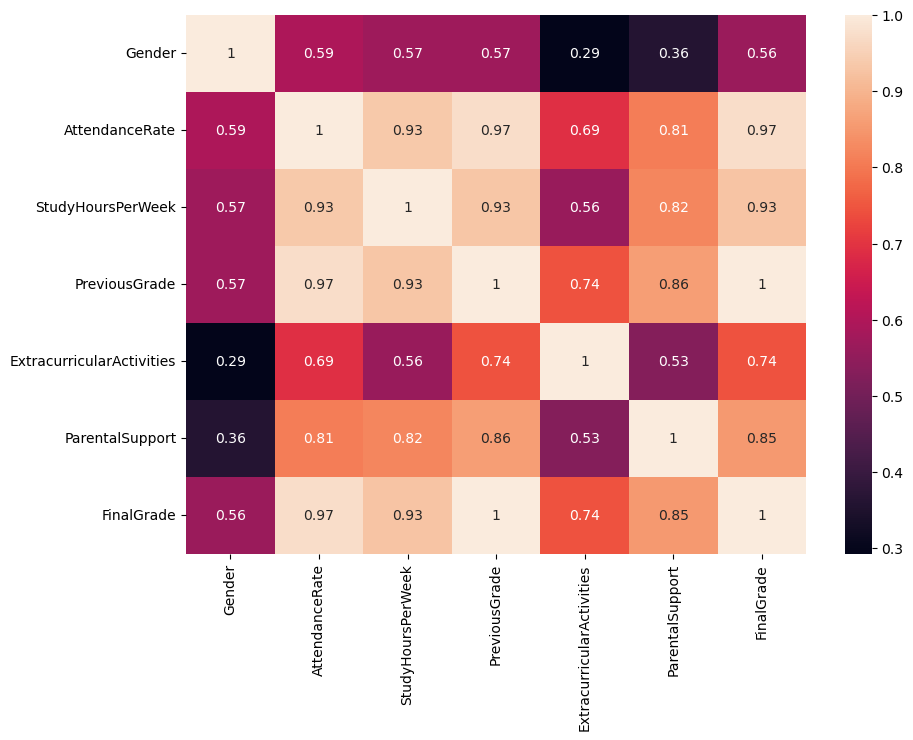

In [18]:
relations = new_df.corr()

plt.figure(figsize=(10,7))
sns.heatmap(data=relations, annot=True)

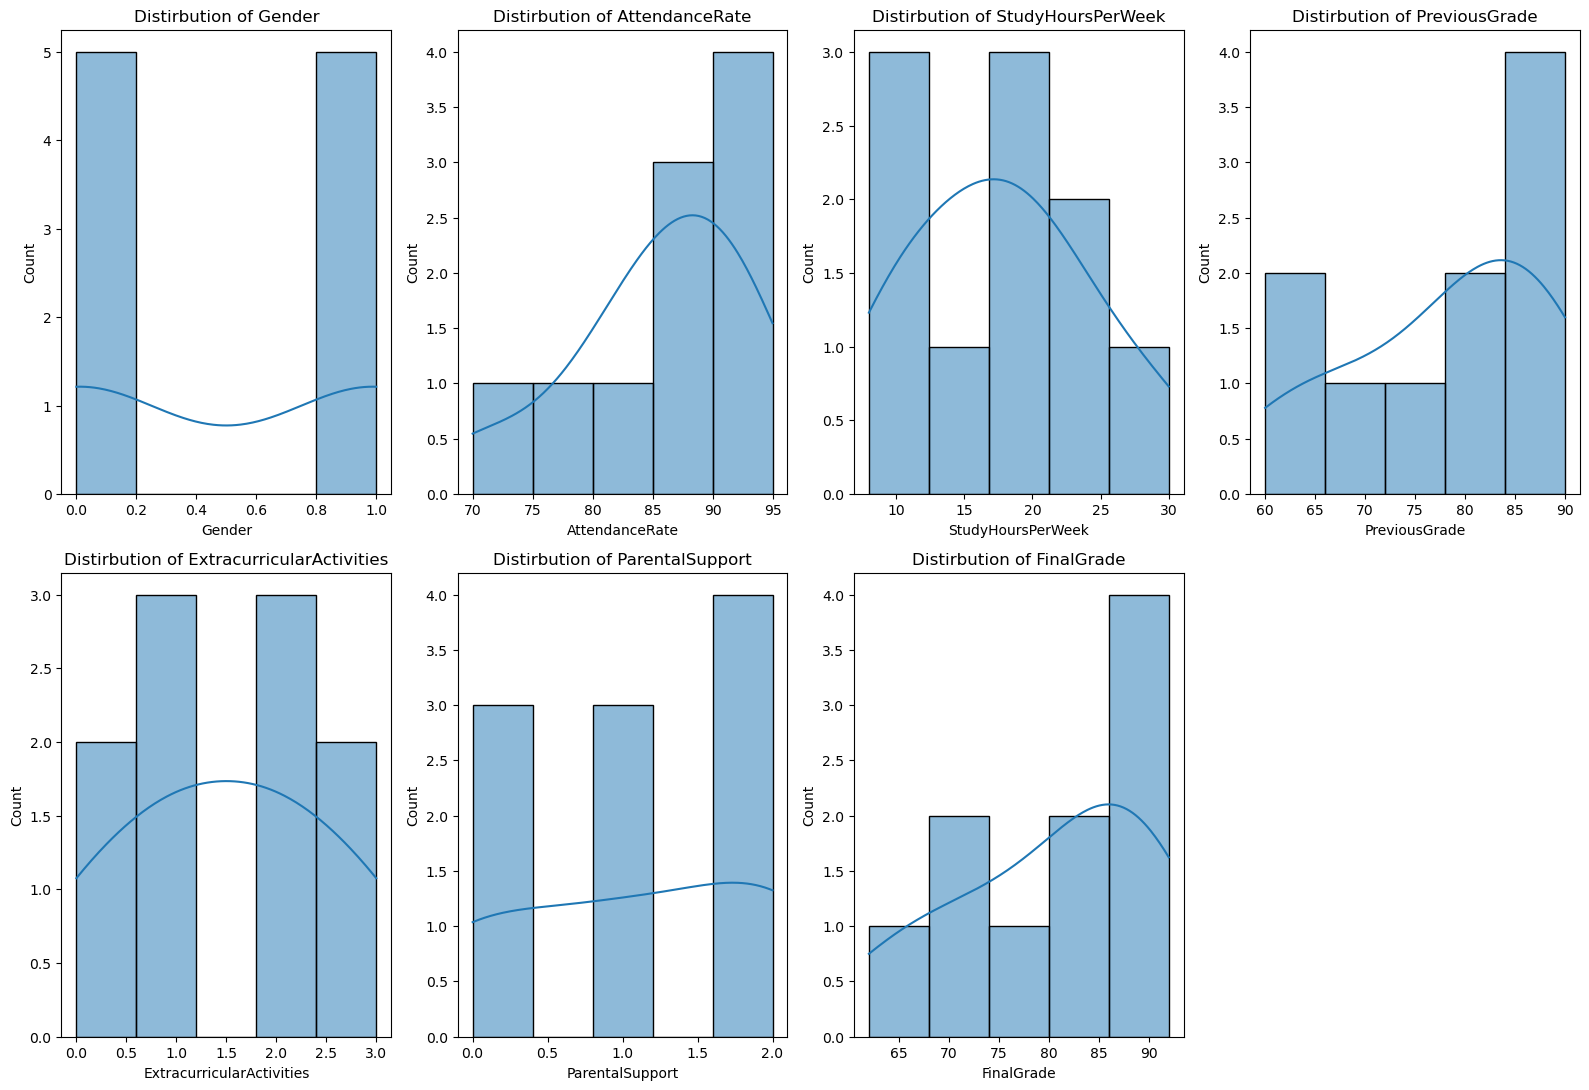

In [21]:
plot_distribution(new_df, "hist")

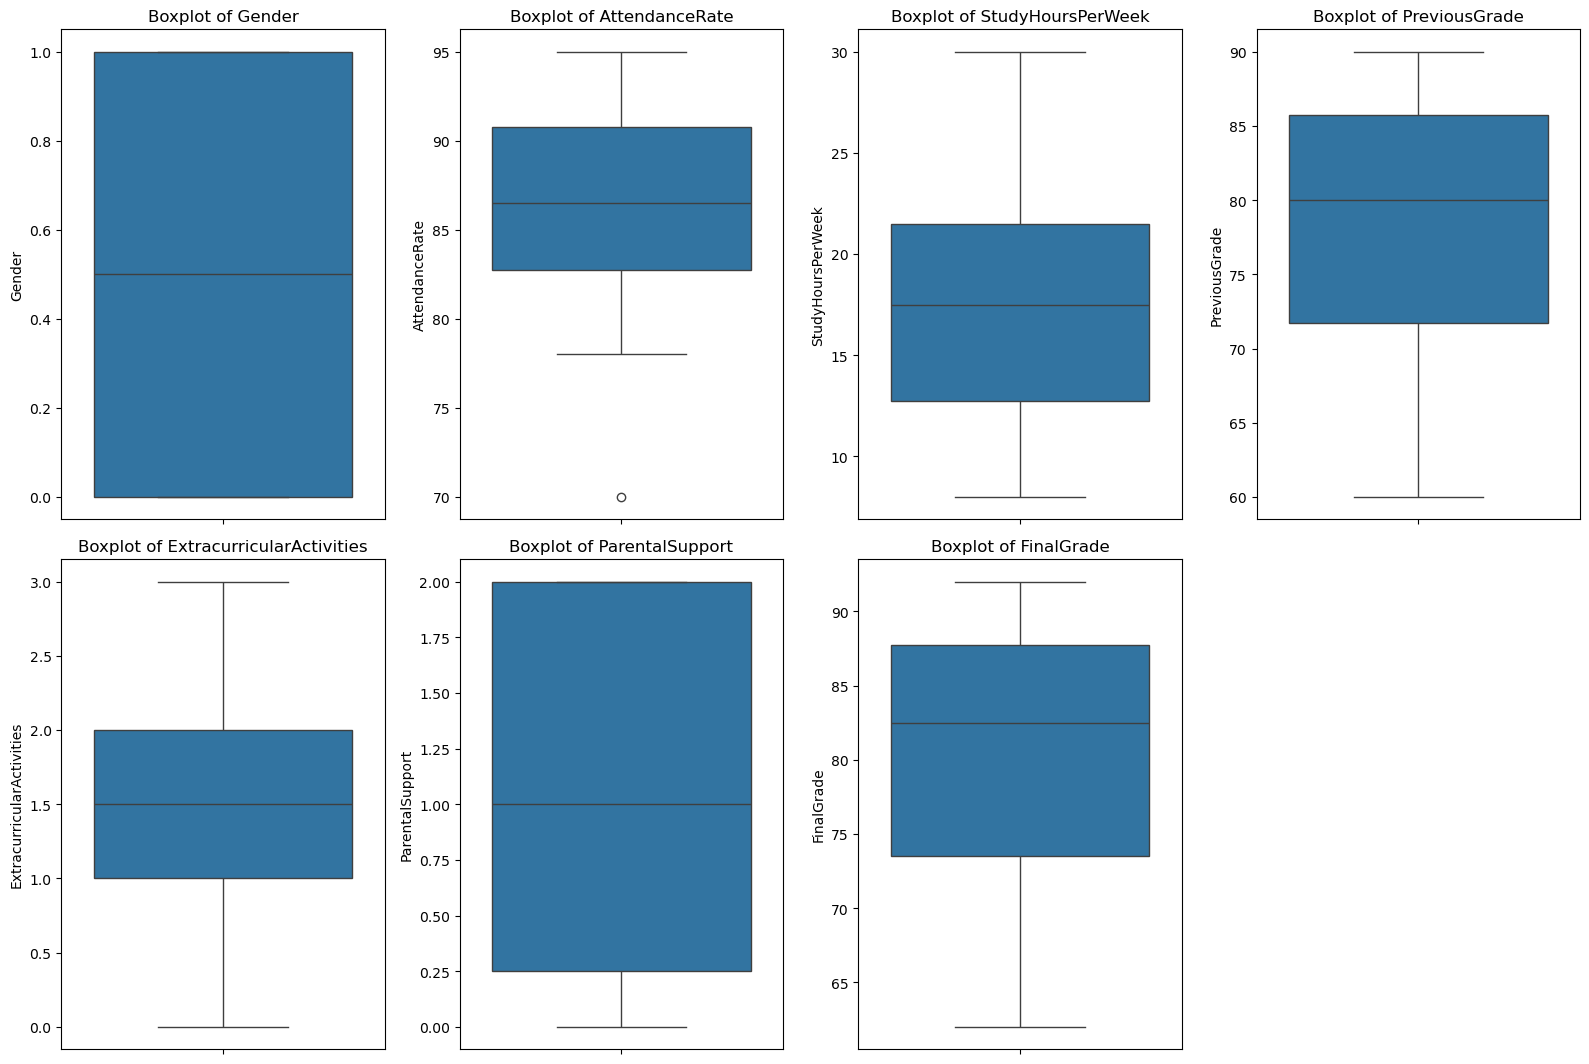

In [22]:
plot_distribution(new_df, "box")

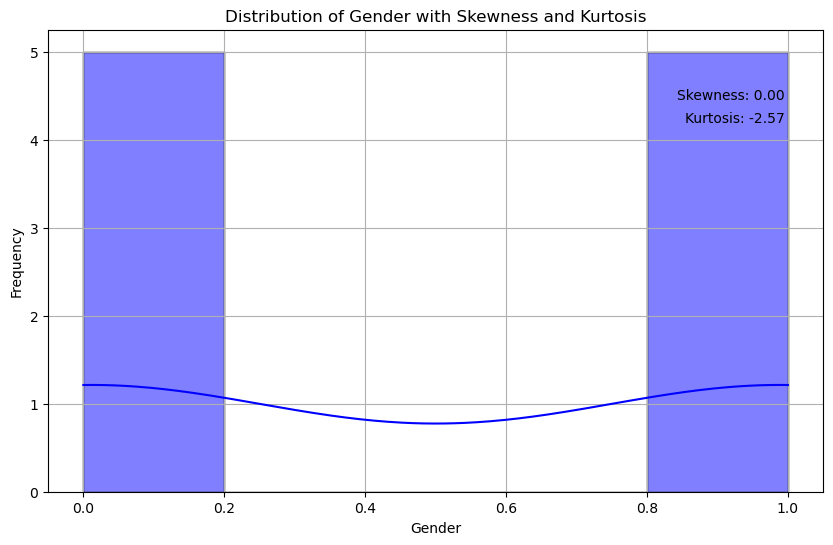

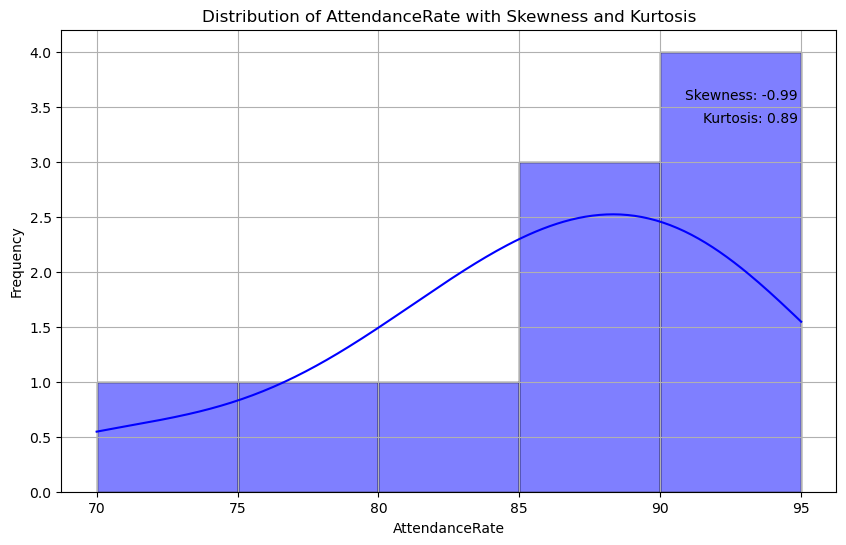

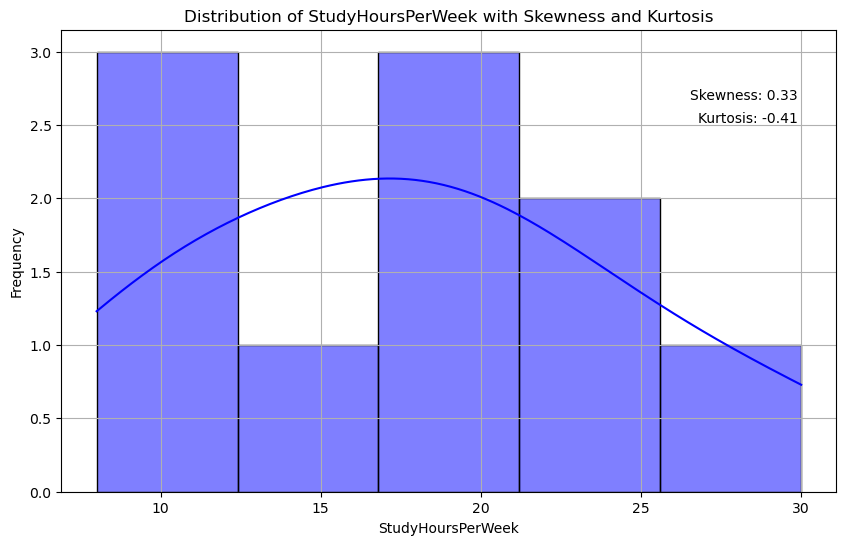

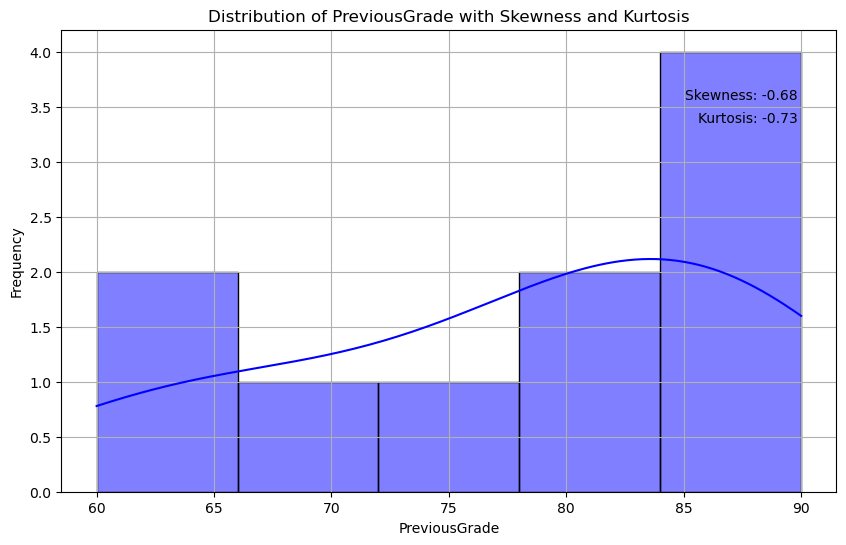

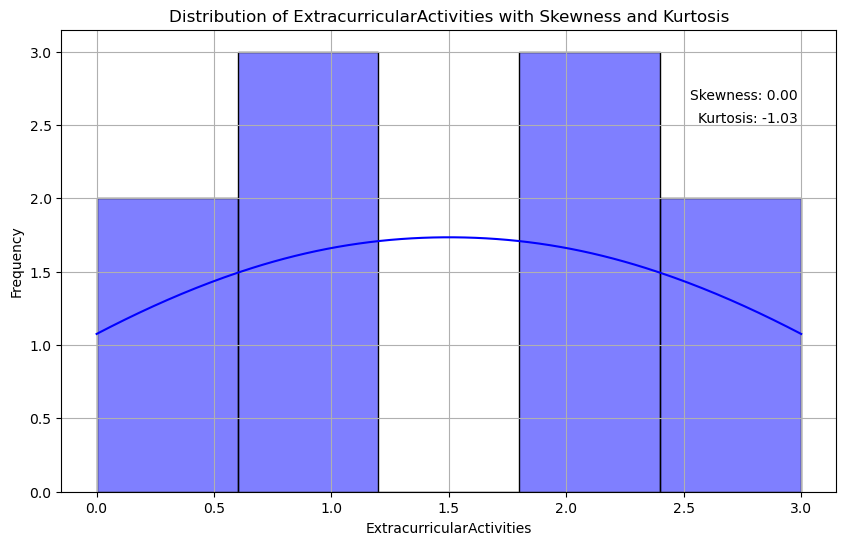

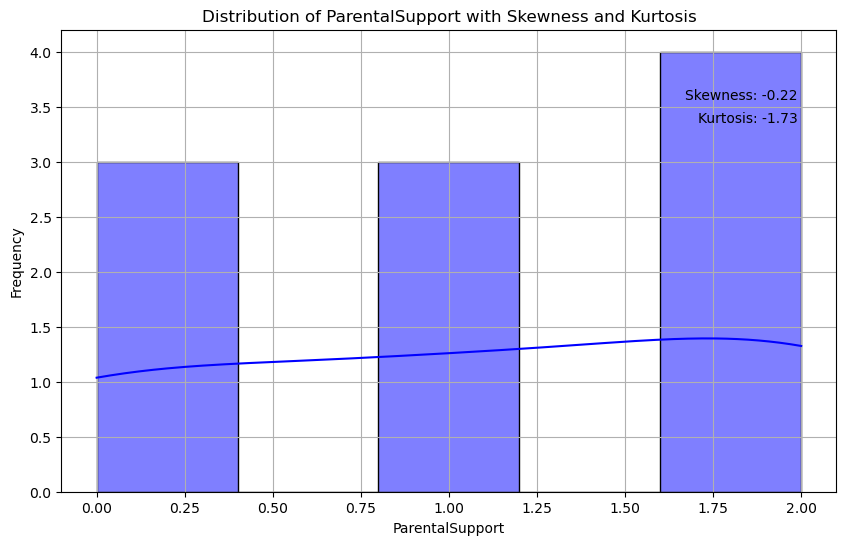

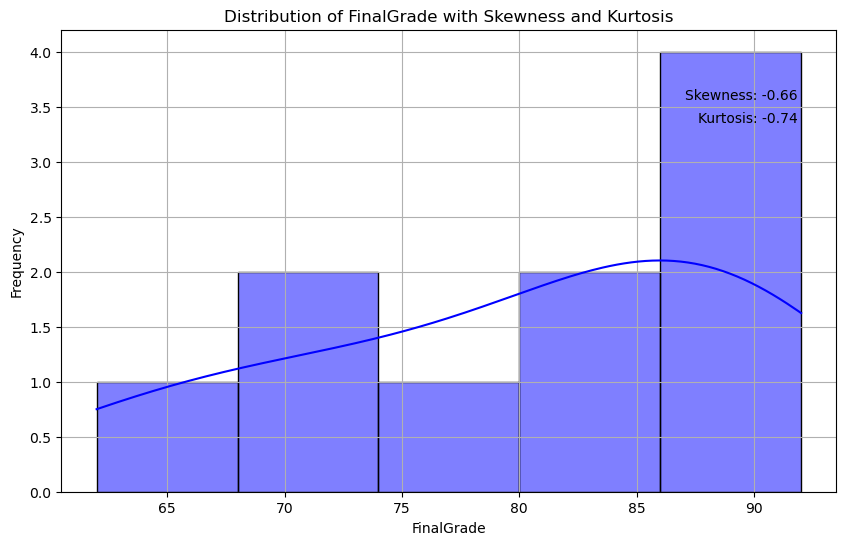

In [24]:
for col in new_df.columns:
  dist_plot(new_df, col)

In [25]:
new_df

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,0,85,15,78,1,2,80
1,1,90,20,85,2,1,87
2,0,78,10,65,0,0,68
3,0,92,25,90,3,2,92
4,1,88,18,82,2,1,85
5,1,95,30,88,1,2,90
6,0,70,8,60,0,0,62
7,1,85,17,77,1,1,78
8,0,82,12,70,2,0,72
9,1,91,22,86,3,2,88


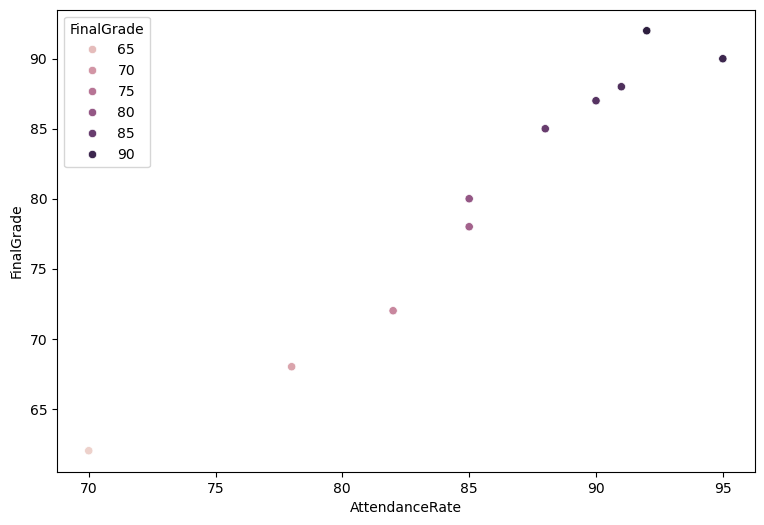

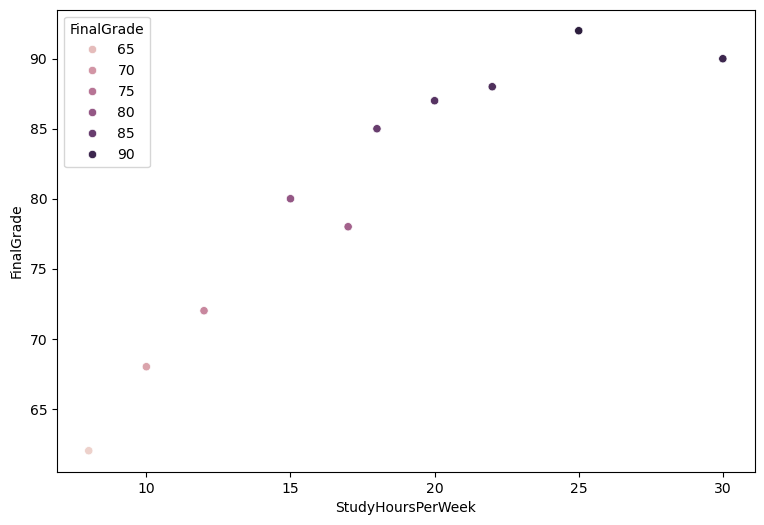

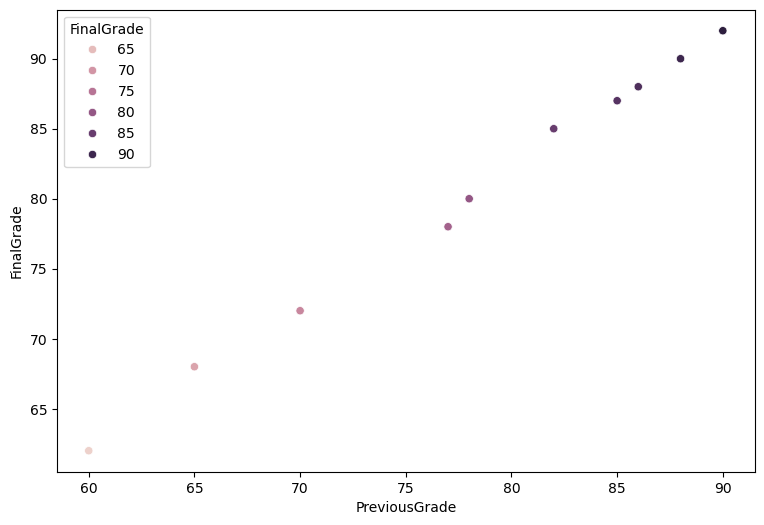

In [28]:
columns = ["AttendanceRate", "StudyHoursPerWeek", "PreviousGrade"]

for col in columns:
  plt.figure(figsize=(9, 6))
  sns.scatterplot(data=new_df, x=col, y="FinalGrade", hue="FinalGrade")
  plt.show()

In [33]:
categorical_types = df.select_dtypes(include="object")
numeric_types = df.select_dtypes(exclude="object").drop("FinalGrade", axis=1)

# Create Preproccessor

In [36]:
preprocessor = create_preprocessor(numeric_types.columns, categorical_types.columns)
preprocessor

ColumnTransformer(transformers=[('Categorical',
                                 Pipeline(steps=[('Encoder', OneHotEncoder())]),
                                 Index(['Gender', 'ParentalSupport'], dtype='object')),
                                ('Numeric',
                                 Pipeline(steps=[('Scaler', MinMaxScaler())]),
                                 Index(['AttendanceRate', 'StudyHoursPerWeek', 'PreviousGrade',
       'ExtracurricularActivities'],
      dtype='object'))])

# Separate Features

In [37]:
X = df.drop("FinalGrade", axis=1)
y = df["FinalGrade"]

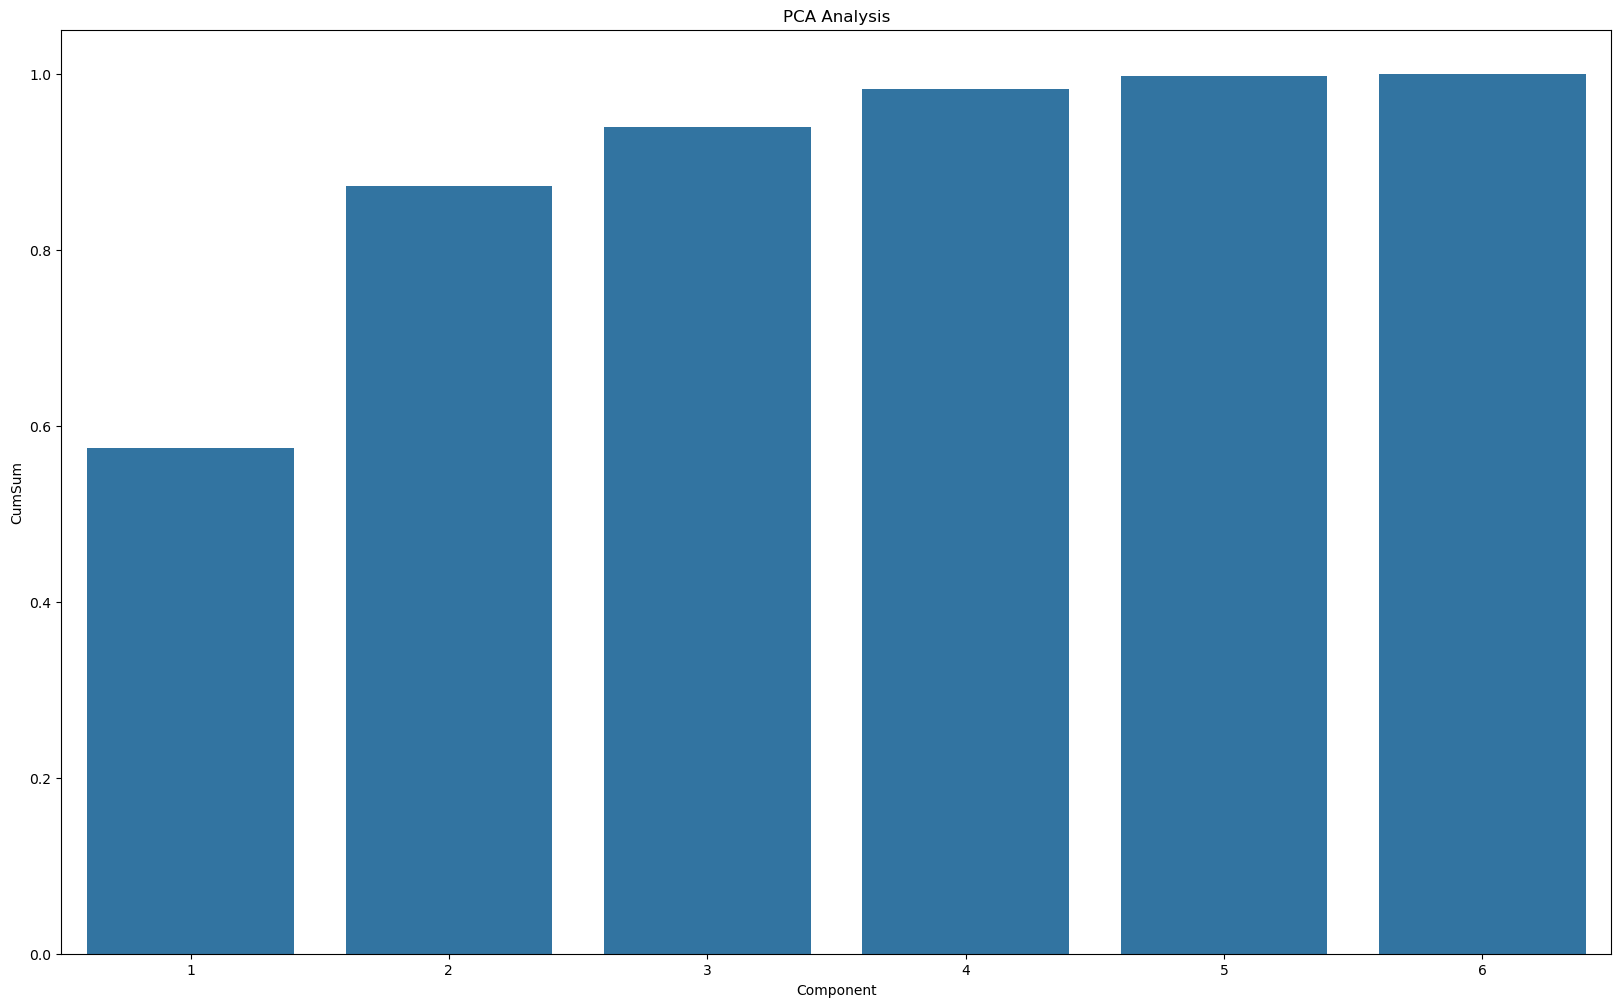

,Component,CumSum
0,1,0.574647
1,2,0.872180
2,3,0.938780
3,4,0.981926
4,5,0.997586
5,6,0.999786


In [41]:
pca_analysis(X, preprocessor)

In [42]:
MAE = make_scorer(score_func=mean_absolute_error, greater_is_better =False)
MSE = make_scorer(score_func=mean_squared_error, greater_is_better=False)
R2 = make_scorer(score_func=r2_score, greater_is_better=True)
EXP_VAR = make_scorer(score_func=explained_variance_score, greater_is_better=True)

In [44]:
model_names = ["DUMMY"]
models = get_selected_models(model_names)
test_selected_models(preprocessor, model_names, models, X, y, MSE)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,DUMMY,-113.284,13290.793,115.286,9.111,113.284,10.643,-0.235,-0.235


In [51]:
model_names = ["SVR"]
models = get_selected_models(model_names)
kbest = mutual_info_regression
test_kbest_columns(preprocessor, X, y, models[0], model_names[0], kbest)

,Model,K,MAE,MSE,RMSE,R2,Explained Var
0,SVR,1,4.898431,30.186009,5.494180,0.373572,0.385379
1,SVR,2,5.118824,34.294203,5.856125,0.288317,0.312010
2,SVR,3,5.153369,34.673848,5.888450,0.280439,0.300705
3,SVR,4,5.445856,40.340217,6.351395,0.162849,0.177944
4,SVR,5,5.435053,38.648790,6.216815,0.197950,0.222519
5,SVR,6,5.711783,38.872393,6.234773,0.193310,0.199974


In [52]:
kbest = f_regression
test_kbest_columns(preprocessor, X, y, models[0], model_names[0], kbest)

,Model,K,MAE,MSE,RMSE,R2,Explained Var
0,SVR,1,4.898431,30.186009,5.494180,0.373572,0.385379
1,SVR,2,5.118824,34.294203,5.856125,0.288317,0.312010
2,SVR,3,5.153369,34.673848,5.888450,0.280439,0.300705
3,SVR,4,5.445856,40.340217,6.351395,0.162849,0.177944
4,SVR,5,5.435053,38.648790,6.216815,0.197950,0.222519
5,SVR,6,5.711783,38.872393,6.234773,0.193310,0.199974


In [53]:
model_names = ["LR", "SVR", "KNN"]
models = get_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_regression, k=5)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,LR,-1.071,1.326,1.151,0.809,0.967,0.992,0.989,0.990
2,KNN,-55.906,5033.354,70.946,5.860,59.012,2.772,0.357,0.391
1,SVR,-111.279,13003.536,114.033,9.547,111.753,3.251,-0.218,-0.194


In [67]:
model_names = ["LR", "SVR", "KNN"]
models = get_selected_models(model_names)
kbest = SelectKBest(score_func=f_regression, k=5)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,LR,-0.926,0.493,0.702,0.886,0.926,0.981,0.990,0.990
2,KNN,-43.036,3663.175,60.524,5.220,43.036,2.561,0.531,0.595
1,SVR,-111.728,16375.698,127.968,9.139,111.728,3.251,-0.218,-0.173


In [61]:
model_names = ["DTR", "RFR", "XGB", "GBR", "LASSO", "RIDGE"]
models = get_selected_models(model_names)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
3,GBR,-7.946,120.188,10.963,2.351,8.844,1.724,0.904,0.904
5,RIDGE,-11.609,370.027,19.236,2.606,11.609,1.846,0.873,0.875
1,RFR,-12.037,431.309,20.768,2.360,12.350,1.875,0.865,0.866
2,XGB,-15.305,179.054,13.381,3.473,15.305,1.978,0.833,0.857
0,DTR,-17.700,345.690,18.593,3.800,25.000,2.236,0.728,0.755
4,LASSO,-27.451,889.358,29.822,4.439,27.451,2.289,0.701,0.702


In [62]:
params = {
  'RIDGE': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'LASSO': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 5000, 10000]
    },
  
    'DTR': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'RFR': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'GBR': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 4, 6],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 10, 15],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [10, 30, 50],
        'model__p': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
        'model__reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'model__reg_lambda': [1, 1.5, 2.0]  # L2 regularization term on weights
    }
}

In [65]:
model_names = ["XGB", "GBR", "RFR","LASSO", "RIDGE", "KNN", "SVR"]
new_models = get_selected_models(model_names)
optimization_search(preprocessor, model_names, new_models, X, y, RandomizedSearchCV, params, MSE, kbest)

The Best Param: {'model__subsample': 1.0, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__gamma': 0.1, 'model__colsample_bytree': 0.6} for Model: XGB
The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 7, 'model__learning_rate': 0.1} for Model: GBR
The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10, 'model__max_depth': None} for Model: RFR
The Best Param: {'model__max_iter': 5000, 'model__alpha': 0.01} for Model: LASSO
The Best Param: {'model__solver': 'cholesky', 'model__alpha': 0.1} for Model: RIDGE
The Best Param: {'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 3, 'model__leaf_size': 30, 'model__algorithm': 'brute'} for Model: KNN
The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 10} for Model: SVR


/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    resul

,Model,MAE,MSE,RMSE,R2,Explained Var
3,LASSO,0.764090,1.102562,1.050029,0.977119,0.978251
4,RIDGE,1.551846,2.713361,1.647228,0.943692,0.945626
5,KNN,1.323562,3.197850,1.788253,0.933637,0.955651
1,GBR,1.788641,3.269546,1.808189,0.932150,0.955266
0,XGB,2.447521,7.183119,2.680134,0.850934,0.930403
6,SVR,3.276482,18.186315,4.264542,0.622593,0.745199
2,RFR,6.940833,61.376503,7.834316,-0.273702,0.000000


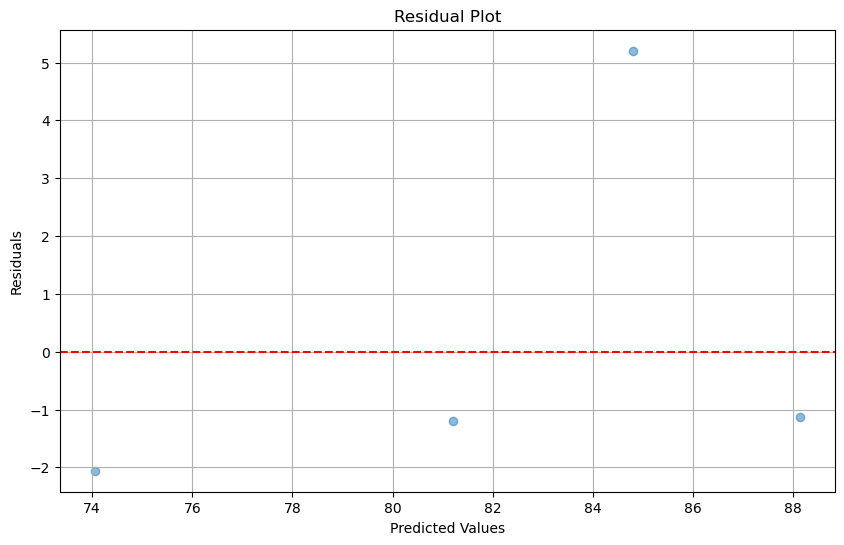

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
pipeline = create_sklearn_pipeline(preprocessor, lr, kbest)
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [69]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

In [70]:
transformed_features = get_feature_names(pipeline.named_steps['preprocessor'])

In [72]:
gbc = GradientBoostingRegressor(
  n_estimators=200, 
  min_samples_split=4,
  min_samples_leaf=1,
  max_depth=7,
  learning_rate=0.1
)
pipeline = create_sklearn_pipeline(preprocessor, gbc, kbest)
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)


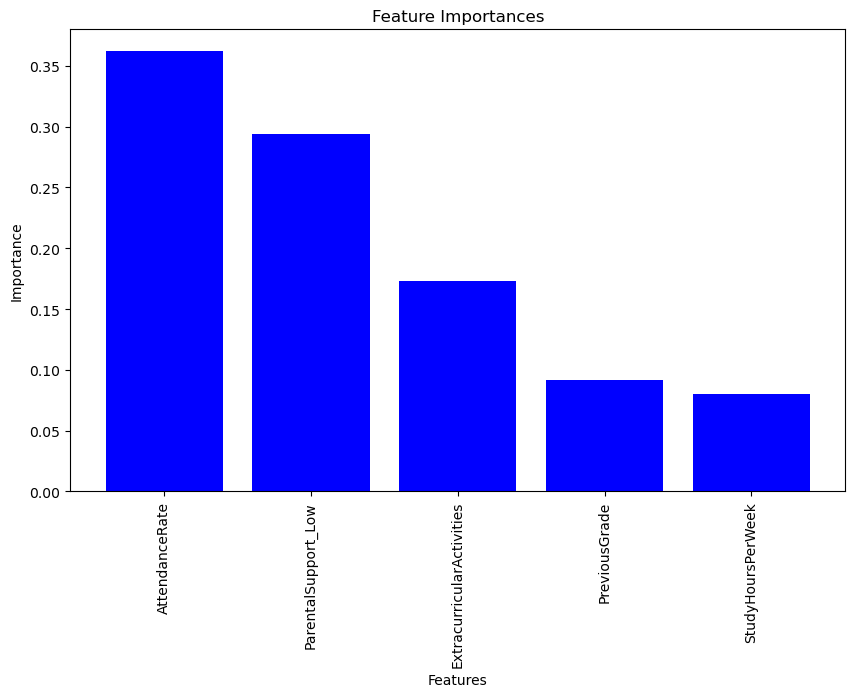

In [73]:
selected_mask = pipeline.named_steps['Feature Selection'].get_support()

selected_features = [feature for is_selected, feature in zip(selected_mask, transformed_features) if is_selected]
feature_importances = pipeline.named_steps['model'].feature_importances_

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), [selected_features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()